In [ ]:
#https://stackoverflow.com/questions/65073549/combine-and-sum-values-of-overlapping-polygons-in-geopandas

In [1]:
from shapely.geometry import Polygon
from shapely.ops import linemerge, unary_union, polygonize
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm
from geocube.api.core import make_geocube
import rasterio
from rasterio.plot import show
import numpy as np

In [2]:
# 讀取shapefile
gdf = gpd.read_file('merge_N_0617_scene_cloud03_2211to2304.shp')

In [3]:
# 將 cloud_cove 欄位轉換為 float
gdf['cloud_cove'] = gdf['cloud_cove'].astype(float)
# 選擇 cloud_cove 值低於 0.3 的部分
gdf = gdf[gdf['cloud_cove'] < 0.3]

In [3]:
gdf['values'] = 1

<AxesSubplot:>

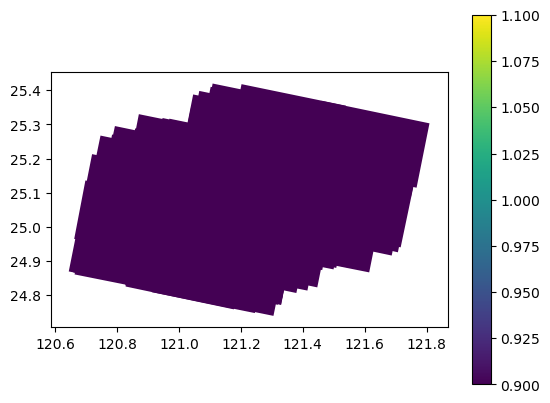

In [4]:
gdf.plot('values', legend=True)

In [5]:
lines = unary_union(linemerge([geom.exterior for geom 
                           in gdf.geometry]))

In [6]:
polygons = list(polygonize(lines))
intersects = gpd.GeoDataFrame({'geometry': polygons})

In [7]:
intersects['sum_overlaps'] = (intersects
                        .sjoin(gdf, predicate='within')
                        .reset_index()
                        .groupby(['index', 'index_right'])
                        .head(1)
                        .groupby('index')
                        .values.sum())

C:\Users\Hom Lee\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:2178: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


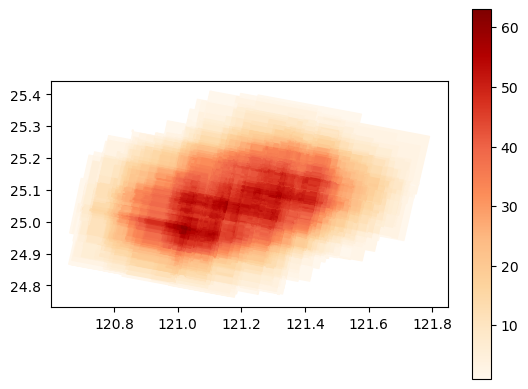

In [8]:
intersects.plot('sum_overlaps', cmap='OrRd', legend=True, edgecolors='face');

In [ ]:
#gdf.crs

In [9]:
intersects = intersects.set_crs(4326, allow_override=True)

In [10]:
intersects.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
intersects['sum_overlaps'] = intersects['sum_overlaps'].fillna(1)
intersects

,geometry,sum_overlaps
0,"POLYGON ((120.68561 25.06109, 120.68870 25.060...",2.0
1,"POLYGON ((120.68870 25.06051, 120.68561 25.061...",1.0
2,"POLYGON ((120.68870 25.06051, 120.69824 25.058...",3.0
3,"POLYGON ((120.69824 25.05874, 120.68870 25.060...",1.0
4,"POLYGON ((120.69824 25.05874, 120.70271 25.057...",2.0
...,...,...
21552,"POLYGON ((121.71095 24.94119, 121.74108 25.074...",1.0
21553,"POLYGON ((121.73590 25.12504, 121.75243 25.121...",2.0
21554,"POLYGON ((121.75243 25.12193, 121.75739 25.121...",2.0
21555,"POLYGON ((121.75739 25.12100, 121.75828 25.120...",1.0


In [12]:
intersects_raster = make_geocube(
        vector_data=intersects,
        measurements=["sum_overlaps"],
        resolution=(-0.001, 0.001),
        fill = 0
    )

In [13]:
intersects_raster.rio.to_raster('intersects_raster_N_scene_below03_2211to2304.tiff')

## 套疊OSM

In [ ]:
# Load image
#img = rasterio.open('intersects_raster_N_02_below03.tiff')
#min_val = img.read(1).min()
#max_val = img.read(1).max()
#left, bottom, right, top = img.bounds

In [14]:
with rasterio.open('intersects_raster_N_scene_below03_2211to2304.tiff') as src:
    # 計算圖像範圍
    left, bottom, right, top = src.bounds
    # 讀取圖像數組並將其轉換為numpy數組
    img = src.read(1)
    img = np.array(img)

In [15]:
# 計算圖像的最小和最大值
min_val, max_val = img.min(), img.max()

In [16]:
# 創建一個地圖
m = folium.Map(location=[gdf.centroid.y.mean(), gdf.centroid.x.mean()], zoom_start=10)

C:\Users\Hom Lee\AppData\Local\Temp\ipykernel_30888\2551620861.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf.centroid.y.mean(), gdf.centroid.x.mean()], zoom_start=10)
C:\Users\Hom Lee\AppData\Local\Temp\ipykernel_30888\2551620861.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf.centroid.y.mean(), gdf.centroid.x.mean()], zoom_start=10)


In [17]:
#https://www.linkedin.com/pulse/visualize-dem-interactive-map-chonghua-yin/?trk=related_artice_Visualize%20DEM%20in%20An%20Interactive%20Map_article-card_title
#https://tinyurl.com/2k28vrse
def colorize(array, cmap='viridis'):
    normed_data = (array - array.min()) / (array.max() - array.min())    
    cm = plt.cm.get_cmap(cmap)    
    return cm(normed_data)

In [18]:
colored_data = colorize(img, cmap='turbo')

In [19]:
# Add raster layer with colormap and transparency
folium.raster_layers.ImageOverlay(
    image=colored_data,
    bounds=[[bottom, left], [top, right]],
    #colormap=lambda x: (x/255, 1-x/255, 0),
    #colormap=colormap,
    opacity=0.5 # Set transparency level
    #mask=(img.read_masks(1) == 255) # Mask out nodata values
).add_to(m)


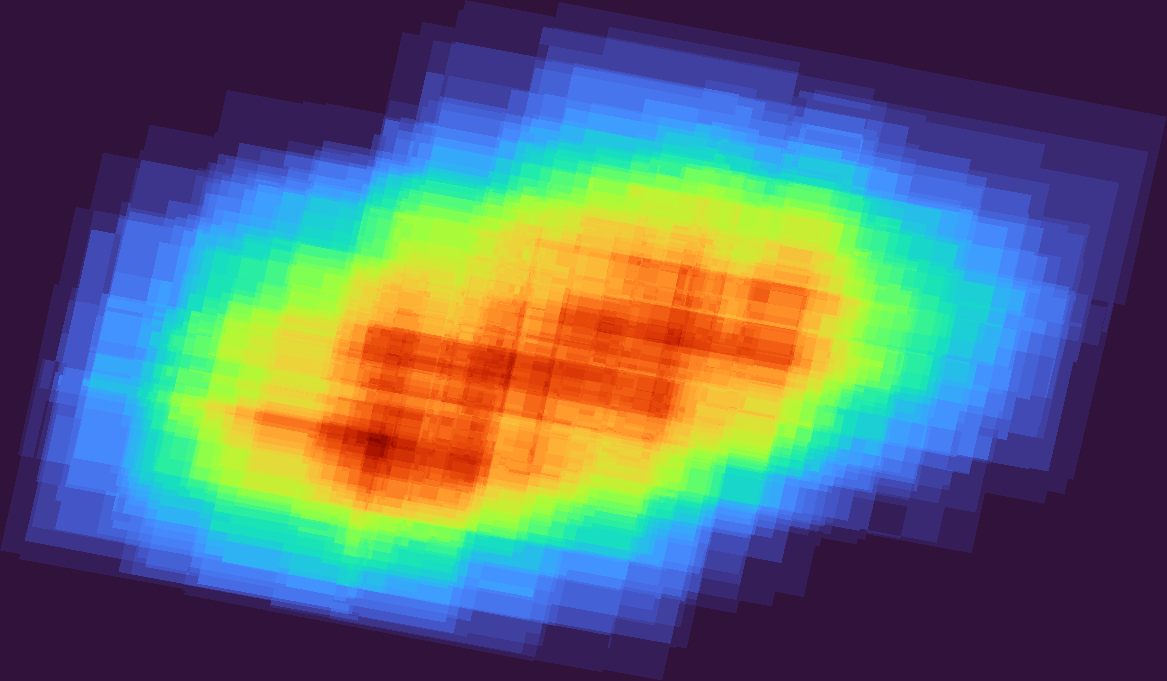

In [20]:
# 添加color map
#colormap.caption = 'sum_overlaps'
#colormap.add_to(m)

# 顯示地圖
m

## 以下不執行

In [ ]:
# 創建color map
# 色彩列表https://www.ebaomonthly.com/window/photo/lesson/colorList.htm
# 方法參考https://github.com/python-visualization/folium/issues/1374
colorlist = ['#E32636', '#FFFF4D', '#16982B', '#0000CD', '#4B0080'][::-1]  
colormap = cm.LinearColormap(colors=colorlist, vmin=min_val, vmax=max_val, caption='Image Colormap')
#colormap = cm.LinearColormap(colors=colorlist, vmin=intersects['sum_overlaps'].min(), vmax=intersects['sum_overlaps'].max(), caption='Image Colormap')
colormap

In [ ]:
# Convert colormap to tuple with length 3
colormap = [colormap(x) for x in np.linspace(int(min_val), int(max_val), (int(max_val)-int(min_val))+1)]
colormap

In [ ]:
# 繪製shapefile
#https://leafletjs.com/reference.html#marker
folium.GeoJson(intersects, style_function=lambda feature: {
        'fillColor': 'red',
        'fillOpacity':0.5,
        'weight':5,
        'stroke':False
        #'color': colormap(feature['properties']['sum_overlaps'])
    }).add_to(m)